In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision
import torchvision.transforms as transforms


df = pd.read_csv("data/winequality-red.csv")

df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [2]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))  # Flatten para MLP
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
    
    return running_loss / len(dataloader), 100. * correct / total

def evaluate(model, dataloader, criterion, device):
    """Función para evaluar el modelo"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data.view(data.size(0), -1))  # Flatten para MLP
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    return test_loss / len(dataloader), 100. * correct / total

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
print(f"Shape: {df.shape}")
print(f"Columnas: {df.columns.tolist()}")
print(f"Tipos: {df.dtypes}")
df.info()

Shape: (1599, 12)
Columnas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Tipos: fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar   

<Axes: >

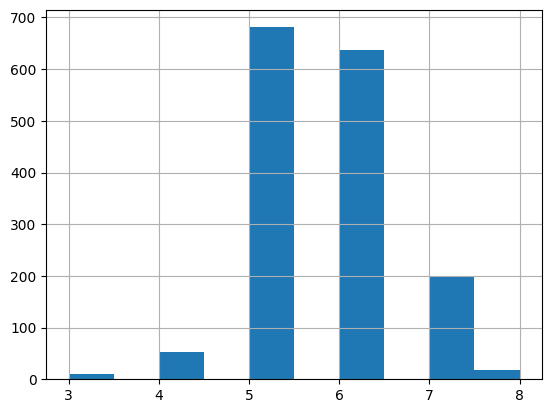

In [4]:
df['quality'].value_counts().sort_index()
df['quality'].hist(bins=10)

In [5]:
df.describe()
df.corr()['quality'].sort_values(ascending=False)

quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

In [16]:
X = df.drop('quality', axis=1).values
y = df['quality'].values

from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=43, stratify=y)

X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)

# Ajustar clases: 3-8 → 0-5
y_train_tensor = torch.LongTensor(y_train - 3)  
y_test_tensor = torch.LongTensor(y_test - 3)

# Recrear datasets con las nuevas etiquetas
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

n_features = X_train.shape[1]
n_classes = len(np.unique(y))

model = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, n_classes)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Más conservador

In [17]:
for epoch in range(50):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"🔥 Época {epoch+1:2d}/50 | "
      f"📈 Train: {train_acc:6.2f}% (loss: {train_loss:.4f}) | "
      f"🎯 Test: {test_acc:6.2f}% (loss: {test_loss:.4f})")

🔥 Época  1/50 | 📈 Train:  36.51% (loss: 1.7197) | 🎯 Test:  50.62% (loss: 1.6386)
🔥 Época  2/50 | 📈 Train:  52.23% (loss: 1.5682) | 🎯 Test:  55.00% (loss: 1.5004)
🔥 Época  3/50 | 📈 Train:  54.34% (loss: 1.4371) | 🎯 Test:  55.31% (loss: 1.3861)
🔥 Época  4/50 | 📈 Train:  54.26% (loss: 1.3332) | 🎯 Test:  56.88% (loss: 1.3011)
🔥 Época  5/50 | 📈 Train:  55.28% (loss: 1.2584) | 🎯 Test:  56.56% (loss: 1.2419)
🔥 Época  6/50 | 📈 Train:  55.12% (loss: 1.2060) | 🎯 Test:  56.88% (loss: 1.1995)
🔥 Época  7/50 | 📈 Train:  55.43% (loss: 1.1681) | 🎯 Test:  58.44% (loss: 1.1667)
🔥 Época  8/50 | 📈 Train:  56.22% (loss: 1.1394) | 🎯 Test:  59.06% (loss: 1.1404)
🔥 Época  9/50 | 📈 Train:  56.37% (loss: 1.1155) | 🎯 Test:  59.38% (loss: 1.1181)
🔥 Época 10/50 | 📈 Train:  58.01% (loss: 1.0959) | 🎯 Test:  58.75% (loss: 1.0998)
🔥 Época 11/50 | 📈 Train:  57.39% (loss: 1.0799) | 🎯 Test:  59.38% (loss: 1.0837)
🔥 Época 12/50 | 📈 Train:  57.78% (loss: 1.0662) | 🎯 Test:  59.38% (loss: 1.0707)
🔥 Época 13/50 | 📈 Train:  58

In [27]:
# EXPERIMENTO: Clasificación binaria Good/Bad
print("=== MODELO BINARIO GOOD/BAD ===")

# Convertir a binario: 3,4,5 → 0 (Bad), 6,7,8 → 1 (Good)
y_binary = (y >= 6).astype(int)  # True/False → 1/0
print(f"Distribución binaria: {np.bincount(y_binary)}")
print(f"Bad wines (3-5): {np.sum(y_binary == 0)}")
print(f"Good wines (6-8): {np.sum(y_binary == 1)}")

# Split train/test para binario
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_scaled, y_binary, test_size=0.2, random_state=43, stratify=y_binary
)

# Convertir a tensores
X_train_bin_tensor = torch.FloatTensor(X_train_bin)
X_test_bin_tensor = torch.FloatTensor(X_test_bin)
y_train_bin_tensor = torch.LongTensor(y_train_bin)  # Ya están en 0-1
y_test_bin_tensor = torch.LongTensor(y_test_bin)

# Crear datasets binarios
train_dataset_bin = data.TensorDataset(X_train_bin_tensor, y_train_bin_tensor)
test_dataset_bin = data.TensorDataset(X_test_bin_tensor, y_test_bin_tensor)

# DataLoaders binarios
train_loader_bin = data.DataLoader(train_dataset_bin, batch_size=128, shuffle=True)
test_loader_bin = data.DataLoader(test_dataset_bin, batch_size=128, shuffle=False)

# Modelo binario (solo 2 clases de salida)
model_binary = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)  # Solo 2 clases: Bad/Good
)

model_binary = model_binary.to(device)

criterion_bin = nn.CrossEntropyLoss()
optimizer_bin = optim.SGD(model_binary.parameters(), lr=0.01)

=== MODELO BINARIO GOOD/BAD ===
Distribución binaria: [744 855]
Bad wines (3-5): 744
Good wines (6-8): 855


In [28]:
# ENTRENAR MODELO BINARIO
print("🚀 Entrenando modelo binario Good/Bad...")

for epoch in range(50):
    train_loss, train_acc = train_epoch(model_binary, train_loader_bin, criterion_bin, optimizer_bin, device)
    test_loss, test_acc = evaluate(model_binary, test_loader_bin, criterion_bin, device)

    print(f"🍷 Época {epoch+1:2d}/50 | "
      f"📈 Train: {train_acc:6.2f}% (loss: {train_loss:.4f}) | "
      f"🎯 Test: {test_acc:6.2f}% (loss: {test_loss:.4f})")

🚀 Entrenando modelo binario Good/Bad...
🍷 Época  1/50 | 📈 Train:  63.49% (loss: 0.6790) | 🎯 Test:  67.81% (loss: 0.6701)
🍷 Época  2/50 | 📈 Train:  68.65% (loss: 0.6662) | 🎯 Test:  69.38% (loss: 0.6594)
🍷 Época  3/50 | 📈 Train:  69.82% (loss: 0.6550) | 🎯 Test:  69.06% (loss: 0.6498)
🍷 Época  4/50 | 📈 Train:  70.60% (loss: 0.6447) | 🎯 Test:  69.69% (loss: 0.6409)
🍷 Época  5/50 | 📈 Train:  71.62% (loss: 0.6351) | 🎯 Test:  70.94% (loss: 0.6324)
🍷 Época  6/50 | 📈 Train:  71.85% (loss: 0.6261) | 🎯 Test:  71.25% (loss: 0.6245)
🍷 Época  7/50 | 📈 Train:  72.48% (loss: 0.6176) | 🎯 Test:  71.25% (loss: 0.6170)
🍷 Época  8/50 | 📈 Train:  72.71% (loss: 0.6096) | 🎯 Test:  71.56% (loss: 0.6099)
🍷 Época  9/50 | 📈 Train:  72.79% (loss: 0.6018) | 🎯 Test:  71.56% (loss: 0.6032)
🍷 Época 10/50 | 📈 Train:  73.18% (loss: 0.5947) | 🎯 Test:  71.25% (loss: 0.5969)
🍷 Época 11/50 | 📈 Train:  74.35% (loss: 0.5878) | 🎯 Test:  71.25% (loss: 0.5911)
🍷 Época 12/50 | 📈 Train:  74.75% (loss: 0.5814) | 🎯 Test:  71.88% (lo